# Online NMF Financial Demo

This notebook walks through a minimal workflow for financial time-series using the `OnlineNMF` class.
We'll download market data, prepare it for modeling, train Online NMF, inspect the learned dictionary, and finish with a simple hyperparameter exploration.


## Environment Setup

We keep everything self-contained inside the repository so the notebook can run from a clean checkout.

In [1]:
from pathlib import Path
import sys
import torch
import numpy as np
import pandas as pd
import plotly
import logging
logging.disable(logging.CRITICAL)

PROJECT_ROOT = Path.cwd().resolve()
if PROJECT_ROOT.name == 'notebooks':
    PROJECT_ROOT = PROJECT_ROOT.parent
SRC_DIR = PROJECT_ROOT / 'src'
RESULTS_DIR = PROJECT_ROOT / 'results' / 'financial_markets' / 'demo'
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

print(f"Project root: {PROJECT_ROOT}")
print(f"Results dir: {RESULTS_DIR}")

Project root: C:\Users\arbio\OneDrive\Bureau\centrale supelec\MVA\ML for timeseries\Dict Learning and online NMF\onmf-timeseries
Results dir: C:\Users\arbio\OneDrive\Bureau\centrale supelec\MVA\ML for timeseries\Dict Learning and online NMF\onmf-timeseries\results\financial_markets\demo


## Load and Prepare Financial Data

We rely on the existing preprocessing utility which handles data download, train/test splits, and scaling with leakage prevention.

In [2]:
from datetime import date
from onmf.preprocessing import prepare_financial_data

DATA_CONFIG = {
    'tickers': ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA'],
    'start': '2020-01-01',
    'end': None,
    'features': ['Close', 'High', 'Low', 'Open'],
    'train_ratio': 0.8,
    'compute_returns': False,
}

X_train, X_test, original_data, metadata = prepare_financial_data(
    tickers=DATA_CONFIG['tickers'],
    start=DATA_CONFIG['start'],
    end=DATA_CONFIG['end'],
    features=DATA_CONFIG['features'],
    train_ratio=DATA_CONFIG['train_ratio'],
    compute_returns=DATA_CONFIG['compute_returns'],
    scaling_method='minmax'
)

### Glimpse of the raw data

The original dataframe keeps multi-asset columns so we can inspect prices/volumes directly.

In [3]:
display(original_data.tail())

Price            Close                                                  \
Ticker            AAPL        AMZN       GOOGL        MSFT        TSLA   
Date                                                                     
2025-11-07  268.470001  244.410004  278.829987  496.820007  429.519989   
2025-11-10  269.429993  248.399994  290.100006  506.000000  445.230011   
2025-11-11  275.250000  249.100006  291.309998  508.679993  439.619995   
2025-11-12  273.470001  244.199997  286.709991  511.140015  430.600006   
2025-11-13  272.950012  237.580002  278.570007  503.290009  401.989990   

Price             High                                                  \
Ticker            AAPL        AMZN       GOOGL        MSFT        TSLA   
Date                                                                     
2025-11-07  272.290009  244.899994  283.779999  499.380005  439.359985   
2025-11-10  273.730011  251.750000  290.799988  506.850006  449.670013   
2025-11-11  275.910004  249.750000  291.920013  509.600006  442.489990   
2025-11-12  275.730011  250.369995  292.010010  511.670013  442.329987   
2025-11-13  276.700012  243.750000  282.839996  513.500000  424.500000   

Price              Low                                                  \
Ticker            AAPL        AMZN       GOOGL        MSFT        TSLA   
Date                                                                     
2025-11-07  266.769989  238.490005  275.190002  493.250000  421.880005   
2025-11-10  267.459991  245.589996  282.859985  498.799988  433.359985   
2025-11-11  269.799988  247.229996  287.320007  502.350006  432.359985   
2025-11-12  271.700012  243.750000  283.690002  499.119995  426.559998   
2025-11-13  272.089996  236.500000  277.239990  501.290009  396.339996   

Price             Open                                                  
Ticker            AAPL        AMZN       GOOGL        MSFT        TSLA  
Date                                                                    
2025-11-07  269.799988  242.899994  283.209991  496.950012  437.920013  
2025-11-10  268.959991  248.339996  284.420013  500.040009  439.600006  
2025-11-11  269.809998  248.410004  287.750000  504.799988  439.399994  
2025-11-12  275.000000  250.240005  291.679993  509.359985  442.149994  
2025-11-13  274.109985  243.050003  282.339996  510.309998  423.130005

## Train Online NMF

We instantiate `OnlineNMF` with a reasonable configuration for the current dataset. Feel free to tweak the hyperparameters and re-run the cell.

In [ ]:
from onmf.model import OnlineNMF

MODEL_CONFIG = {
    'r': 12,
    'k': 6,
    'batch_size': 32,
    'N': 180,
    'max_iter': 200,
    'lambda_': 0.4,
    'beta': 0.9,
    'lambda_minB': 0.2,
    'beta_minB': 0.95,
    'lambda_pred': 0.4,
}

onmf = OnlineNMF(
    r=MODEL_CONFIG['r'],
    k=MODEL_CONFIG['k'],
    batch_size=MODEL_CONFIG['batch_size'],
    N=MODEL_CONFIG['N'],
    max_iter=MODEL_CONFIG['max_iter'],
)

_ = onmf.fit(
    X_train,
    lambda_=MODEL_CONFIG['lambda_'],
    beta=MODEL_CONFIG['beta'],
    lambda_minB=MODEL_CONFIG['lambda_minB'],
    beta_minB=MODEL_CONFIG['beta_minB'],
)

print(f"Dictionary learned with shape: {tuple(onmf.W_final.shape)}")

Dictionary learned with shape: (20, 6, 12)


### One-step-ahead prediction

`OnlineNMF.predict` consumes any history to make the next timestep prediction. Here we supply all available training data to illustrate the call.

In [5]:
history = X_train
prediction = onmf.predict(history, lambda_pred=MODEL_CONFIG['lambda_pred'])

prediction_series = pd.Series(
    prediction.cpu().numpy(),
    index=metadata['feature_names'],
    name='ONMF forecast',
)

prediction_series.head(10)

Close_AAPL     0.810279
Close_AMZN     0.663106
Close_GOOGL    0.740622
Close_MSFT     0.755708
Close_TSLA     0.752996
High_AAPL      0.764827
High_AMZN      0.797387
High_GOOGL     0.767871
High_MSFT      0.776996
High_TSLA      0.746648
Name: ONMF forecast, dtype: float32

### Visualizing dictionary atoms and training loss

The helper in `src/onmf/visualization.py` already knows how to display the learned patterns. Below we simply render the figures inline.

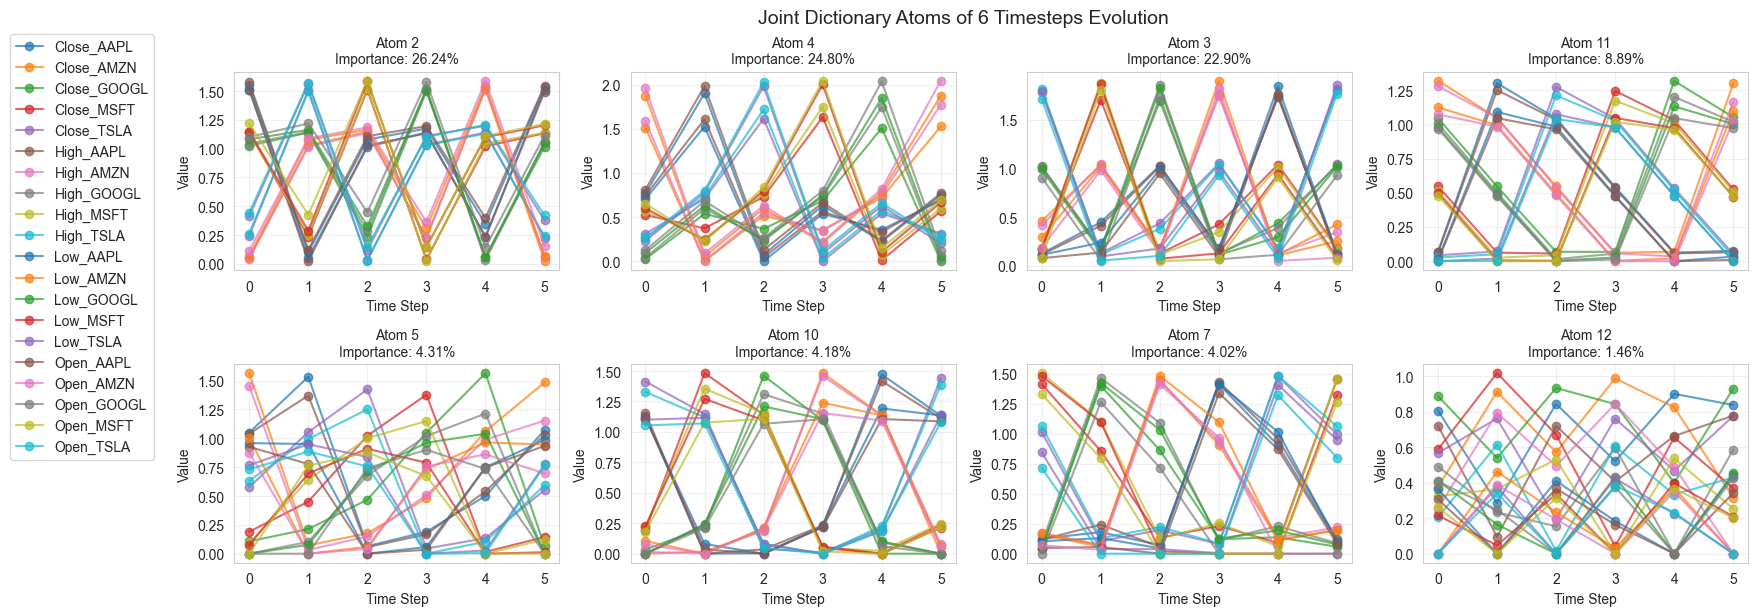

In [6]:
import matplotlib.pyplot as plt
from onmf.visualization import ONMFVisualizer

viz = ONMFVisualizer(onmf, feature_names=metadata['feature_names'])

fig_atoms = viz.plot_dictionary_atoms(top_n=8)
plt.show()

## Lightweight Hyperparameter Exploration

For demonstration, we perform a coarse grid search across a handful of configurations. The score is a simple validation MAE computed by rolling the model forward on a short horizon. Predictions use recursive extrapolation, meaning we use the prediction at timestep t for predicting timestep t+1.


In [7]:
import itertools
from copy import deepcopy
import torch.nn.functional as F

def validation_score(model_params, lambda_pred=0.4, horizon=15):
    model = OnlineNMF(
        r=model_params['r'],
        k=model_params['k'],
        batch_size=model_params.get('batch_size', MODEL_CONFIG['batch_size']),
        N=model_params.get('N', MODEL_CONFIG['N']),
        max_iter=model_params.get('max_iter', MODEL_CONFIG['max_iter']),
    )
    model.fit(
        X_train,
        lambda_=model_params['lambda_'],
        beta=model_params.get('beta', MODEL_CONFIG['beta']),
        lambda_minB=model_params.get('lambda_minB', MODEL_CONFIG['lambda_minB']),
        beta_minB=model_params.get('beta_minB', MODEL_CONFIG['beta_minB']),
    )

    horizon = min(horizon, X_test.shape[0])
    context = X_train.clone() 
    total_error = 0.0
    diff = np.array(metadata["scaler"]['max'] - metadata["scaler"]['min'] + 1e-9)
    m = np.array(metadata["scaler"]['min'])
    for step in range(horizon):
        pred = model.predict(context, lambda_pred=lambda_pred)
        true_val = X_test[step]
        total_error += F.l1_loss(pred * diff + m, true_val * diff + m, reduction='mean').item() 
        context = torch.cat([context, pred.unsqueeze(0)], dim=0)
    return total_error / horizon

param_grid = {
    'r': [8, 12, 16],
    'k': [4, 6],
    'lambda_': [0.3, 0.5],
}

grid_results = []
for r in param_grid['r']:
    for k in param_grid['k']:
        for lam in param_grid['lambda_']:
            params = {'r': r, 'k': k, 'lambda_': lam}
            score = validation_score(params)
            grid_results.append({'params': params, 'val_mae': score})
            print(f"{params} -> MAE={score:.4f}")

grid_results = sorted(grid_results, key=lambda x: x['val_mae'])

grid_results[:3]

C:\Users\arbio\AppData\Local\Temp\ipykernel_26404\51120247.py:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  total_error += F.l1_loss(pred * diff + m, true_val * diff + m, reduction='mean').item()


{'r': 8, 'k': 4, 'lambda_': 0.3} -> MAE=39.6851
{'r': 8, 'k': 4, 'lambda_': 0.5} -> MAE=38.8533
{'r': 8, 'k': 6, 'lambda_': 0.3} -> MAE=35.6472
{'r': 8, 'k': 6, 'lambda_': 0.5} -> MAE=35.5472
{'r': 12, 'k': 4, 'lambda_': 0.3} -> MAE=40.2507
{'r': 12, 'k': 4, 'lambda_': 0.5} -> MAE=39.3977
{'r': 12, 'k': 6, 'lambda_': 0.3} -> MAE=35.2749
{'r': 12, 'k': 6, 'lambda_': 0.5} -> MAE=35.4748
{'r': 16, 'k': 4, 'lambda_': 0.3} -> MAE=40.8709
{'r': 16, 'k': 4, 'lambda_': 0.5} -> MAE=39.7832
{'r': 16, 'k': 6, 'lambda_': 0.3} -> MAE=35.5977
{'r': 16, 'k': 6, 'lambda_': 0.5} -> MAE=35.7359


[{'params': {'r': 12, 'k': 6, 'lambda_': 0.3}, 'val_mae': 35.27493808192272},
 {'params': {'r': 12, 'k': 6, 'lambda_': 0.5}, 'val_mae': 35.47475481281919},
 {'params': {'r': 8, 'k': 6, 'lambda_': 0.5}, 'val_mae': 35.54721990514314}]

## Hyperparameter Optimization with Optuna

For a more intelligent and efficient hyperparameter search, we use Optuna's TPE (Tree-structured Parzen Estimator) sampler with median pruning to reduce the number of trials needed.


In [8]:
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
import torch.nn.functional as F

def objective(trial):
    """Optuna objective function for hyperparameter optimization."""
    # Suggest hyperparameters
    r = trial.suggest_int('r', 6, 20, step=2)
    k = trial.suggest_int('k', 4, 15, step=1)
    N = trial.suggest_int('N', 80, 200, step=20)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    lambda_ = trial.suggest_float('lambda_', 0.1, 1.0, log=True)
    beta = trial.suggest_float('beta', 0.1, 5)
    lambda_pred = trial.suggest_float('lambda_pred', 0.0, 1.0)

    # Create parameter dict
    params = {
        'r': r,
        'k': k,
        'lambda_': lambda_,
        'batch_size': batch_size,
        'N': N,
        'max_iter': 800,
        'beta': beta,
        'lambda_minB': MODEL_CONFIG['lambda_minB'],
        'beta_minB': MODEL_CONFIG['beta_minB'],
    }
    
    try:
        score = validation_score(params, lambda_pred=lambda_pred, horizon=15)
        return score
    except Exception as e:
        print(f"Trial failed with params {params}: {e}")
        return float('inf')

# Create a study with TPE sampler and median pruner for efficient optimization
sampler = TPESampler(seed=42)
pruner = MedianPruner()

study = optuna.create_study(
    direction='minimize',  # minimize MAE
    sampler=sampler,
    pruner=pruner,
)

# Optimize: run trials
print("\n" + "="*70)
print("Hyperparameter Optimization with Optuna (TPE + Median Pruning)")
print("="*70 + "\n")

study.optimize(objective, n_trials=100, show_progress_bar=True)

# Get best trial
best_trial = study.best_trial
print(f"\n✓ Best Trial: {best_trial.number}")
print(f"  Best MAE: {best_trial.value:.4f}")
print(f"  Best Parameters:")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

# Store results in a dataframe for easy inspection
trials_df = study.trials_dataframe()
print("\nTop 5 trials:")
print(trials_df[['number', 'value', 'params_r', 'params_k', 'params_lambda_', 'params_N', 'params_batch_size', 'params_beta', 'params_lambda_pred']].sort_values(by='value', ascending=True).head(5))


c:\Users\arbio\anaconda3\envs\ml-timeseries\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Hyperparameter Optimization with Optuna (TPE + Median Pruning)



  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\arbio\AppData\Local\Temp\ipykernel_26404\51120247.py:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  total_error += F.l1_loss(pred * diff + m, true_val * diff + m, reduction='mean').item()
Best trial: 62. Best value: 21.6382: 100%|██████████| 100/100 [2:12:31<00:00, 79.52s/it] 



✓ Best Trial: 62
  Best MAE: 21.6382
  Best Parameters:
    r: 6
    k: 14
    N: 120
    batch_size: 32
    lambda_: 0.1570570843952475
    beta: 0.11851384701951563
    lambda_pred: 0.6459902575850754

Top 5 trials:
    number       value  params_r  params_k  params_lambda_  params_N  \
2        2  123.866427        14         5        0.326764       120   
56      56   52.024305         8        10        0.346534       100   
34      34   44.425075         6        15        0.200295       100   
69      69   43.019372         6        15        0.171892       120   
38      38   40.954495        14         4        0.232679        80   

    params_batch_size  params_beta  params_lambda_pred  
2                  64     3.002831            0.046450  
56                 32     0.146075            0.507616  
34                 32     0.359267            0.606442  
69                 16     0.256167            0.539329  
38                 16     2.589093            0.429977  


**Visualization of Optuna Optimization**

Visualize the optimization process and parameter importance to understand which hyperparameters matter most.


In [9]:
def ensure_plotly_figure(fig):
    return fig.to_plotly_figure() if hasattr(fig, "to_plotly_figure") else fig

# Plot 1: Optimization history
print("\n" + "="*70)
print("Optuna Optimization History")
print("="*70 + "\n")

fig_history = ensure_plotly_figure(optuna.visualization.plot_optimization_history(study))
fig_history.update_layout(title="Optuna Optimization History", height=500)
fig_history.show()

# Plot 2: Parameter importance
print("\n" + "="*70)
print("Parameter Importance Analysis")
print("="*70 + "\n")
fig_importance = ensure_plotly_figure(optuna.visualization.plot_param_importances(study))
fig_importance.update_layout(title="Parameter Importance Analysis", height=500)
fig_importance.show()

# Plot 3: Parallel coordinates
print("\n" + "="*70)
print("Parallel Coordinate Plot")
print("="*70 + "\n")
fig_parallel = ensure_plotly_figure(optuna.visualization.plot_parallel_coordinate(study))
fig_parallel.update_layout(title="Parallel Coordinate Plot", height=600)
fig_parallel.show()

print("\n" + "="*70)
print("Parameter Slice Plot")
print("="*70 + "\n")

# Plot 4: Slice plot
fig_slice = ensure_plotly_figure(optuna.visualization.plot_slice(study))
fig_slice.update_layout(title="Parameter Slice Plot", height=600)
fig_slice.show()



Optuna Optimization History




Parameter Importance Analysis




Parallel Coordinate Plot




Parameter Slice Plot



### Next steps

- Promote the top configuration into your experiment config (e.g., `examples/financial_markets/config.yaml`): You will need to split your data to train/validation and test, optimize hyperparameters on train and apply them on test data to evaluate how good they generalize.
- Integrate richer metrics or walk-forward validation for production-grade tuning.
- Extend the notebook with domain-specific visualizations tailored to your assets.